# HDR analysis of a squared exponential process

Reference:

https://github.com/openturns/openturns/issues/1710

In [1]:
import openturns as ot
import openturns.viewer as otv
import othdrplot as othdr
import pylab as pl
import tqdm
import numpy as np

In [2]:
def draw_grid(grid, figure_size=(6.0, 6.0)):
    """
    Plot a grid of graphics.
    
    This is a workaround in OT1.16 for #1710
    
    Parameters
    ----------
    grid : ot.GridLayout
        The grid.
    figure_size : a sequence(2)
        The width and height of the figure.
    """
    figure = pl.figure(figsize=figure_size)
    nbrows = grid.getNbRows()
    nbcolumns = grid.getNbColumns()
    for i in range(nbrows):
        for j in range(nbcolumns):
            k = 1 + i + j * nbrows
            graph = grid.getGraph(i, j)
            ax = figure.add_subplot(nbrows, nbcolumns, k)
            _ = otv.View(graph, figure=figure, axes=[ax])
    _ = figure.suptitle(grid.getTitle())
    return figure

In [3]:
xmin = 0.0
step = 0.1
n = 100
timeGrid = ot.RegularGrid(xmin, step, n + 1)

In [4]:
amplitude = [7.0]
scale = [1.5]
covarianceModel = ot.SquaredExponential(scale, amplitude)

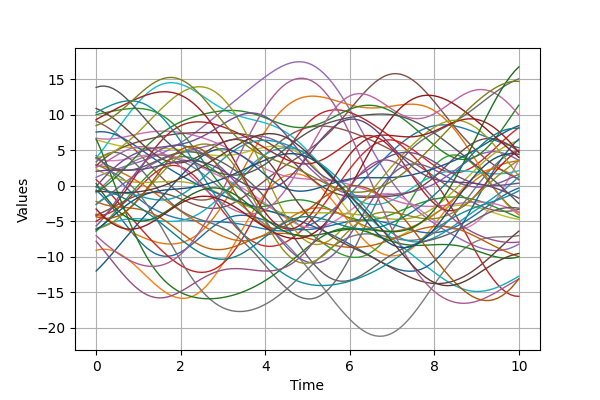

In [5]:
gaussian_process = ot.GaussianProcess(covarianceModel, timeGrid)
sample_size = 50
processSample = gaussian_process.getSample(sample_size)
graph = processSample.drawMarginal(0)
graph.setTitle("")
graph

In [6]:
# KL decomposition
reduction = othdr.KarhunenLoeveDimensionReductionAlgorithm(processSample, 2)
reduction.run()
reducedComponents = reduction.getReducedComponents()

# Distribution fit in reduced space
ks = ot.KernelSmoothing()
reducedDistribution = ks.build(reducedComponents)

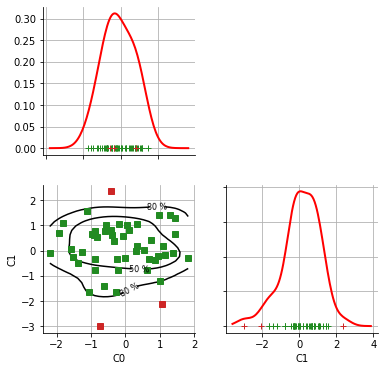

In [7]:
mydp = othdr.HighDensityRegionAlgorithm(
    reducedComponents, reducedDistribution, [0.8, 0.5]
)
mydp.run()
grid = mydp.draw(drawInliers=True)
view = otv.View(grid).getFigure().set_size_inches(6.0, 6.0)

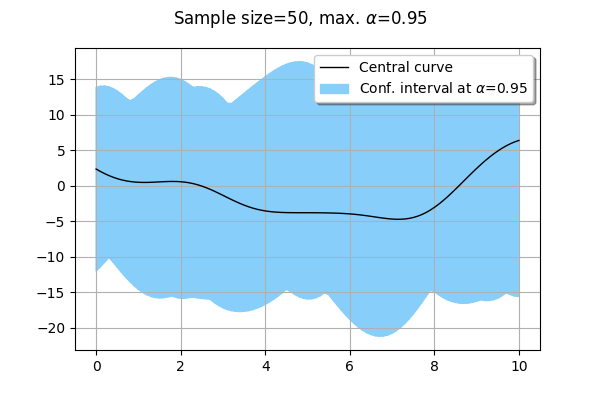

In [8]:
alpha_max = 0.95
hdr = othdr.ProcessHighDensityRegionAlgorithm(
    processSample, reducedComponents, reducedDistribution, [alpha_max, 0.5]
)
hdr.run()
graph = hdr.draw()
graph.setTitle(r"Sample size=%d, max. $\alpha$=%.2f" % (sample_size, alpha_max))
graph

In [9]:
def draw_band(
    gaussian_process, sample_size=500, alpha_max=0.95, number_of_components=2
):
    """
    Draw a confidence band for a gaussian process.

    Uses the Karhunen-Loève decomposition for dimension reduction.

    Parameters
    ----------
    gaussian_process : ot.GaussianProcess
        A Gaussian process.
    sample_size : int, optional
        The sample size. The default is 500.
    alpha_max : float, optional
        The maximum alpha level for outlier selection. The default is 0.95.
    number_of_components : int, optional
        The number of dimensions in the reduced space. The default is 2.

    Returns
    -------
    graph : ot.Graph
        The confidence band at level alpha_max.
    """
    processSample = gaussian_process.getSample(sample_size)
    # KL decomposition
    reduction = othdr.KarhunenLoeveDimensionReductionAlgorithm(
        processSample, number_of_components
    )
    reduction.run()
    reducedComponents = reduction.getReducedComponents()

    # Distribution fit in reduced space
    ks = ot.KernelSmoothing()
    reducedDistribution = ks.build(reducedComponents)
    # HDR
    hdr = othdr.ProcessHighDensityRegionAlgorithm(
        processSample, reducedComponents, reducedDistribution, [alpha_max]
    )
    hdr.run()
    graph = hdr.draw(drawOutliers=False)
    graph.setLegends([""])
    graph.setTitle(r"Sample size=%d, max. $\alpha$=%.2f" % (sample_size, alpha_max))
    return graph

100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


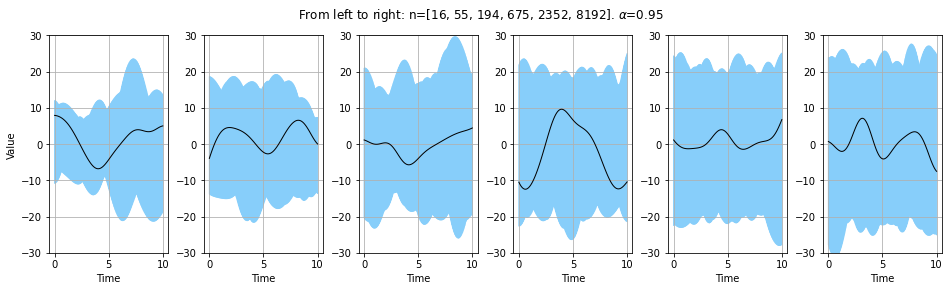

In [10]:
sample_array = [int(i) for i in np.logspace(4, 13, 6, base=2.0)]
grid = ot.GridLayout(1, len(sample_array))
for i in tqdm.tqdm(range(len(sample_array))):
    graph = draw_band(gaussian_process, sample_size=sample_array[i])
    bounding_box = graph.getBoundingBox()
    lower_bound = bounding_box.getLowerBound()
    upper_bound = bounding_box.getUpperBound()
    upper_bound[1] = 30.0
    lower_bound[1] = -upper_bound[1]
    bounding_box.setLowerBound(lower_bound)
    bounding_box.setUpperBound(upper_bound)
    graph.setBoundingBox(bounding_box)
    if i == 0:
        graph.setYTitle("Value")
    graph.setXTitle("Time")
    grid.setGraph(0, i, graph)
grid.setTitle(r"From left to right: n=%s. $\alpha$=%.2f" % (sample_array, alpha_max))
_ = draw_grid(grid, figure_size = (16.0, 4.0))
pl.subplots_adjust(wspace=0.3)

In [11]:
def draw_region(
    gaussian_process,
    sample_size=500,
    alpha_max=0.95,
):
    """
    Draw a confidence region for a gaussian process in reduced 2D plane.

    Uses the Karhunen-Loève decomposition for dimension reduction.

    Parameters
    ----------
    gaussian_process : ot.GaussianProcess
        A Gaussian process.
    sample_size : int, optional
        The sample size. The default is 500.
    alpha_max : float, optional
        The maximum alpha level for outlier selection. The default is 0.95.

    Returns
    -------
    graph : ot.Graph
        The confidence region at level alpha_max.
    """
    number_of_components = 2
    processSample = gaussian_process.getSample(sample_size)
    # KL decomposition
    reduction = othdr.KarhunenLoeveDimensionReductionAlgorithm(
        processSample, number_of_components
    )
    reduction.run()
    reducedComponents = reduction.getReducedComponents()

    # Distribution fit in reduced space
    ks = ot.KernelSmoothing()
    reducedDistribution = ks.build(reducedComponents)
    # HDR
    hdr = othdr.HighDensityRegionAlgorithm(
        reducedComponents, reducedDistribution, [alpha_max]
    )
    hdr.run()
    grid = hdr.draw(drawOutliers=True, drawInliers=True)
    graph = grid.getGraph(1, 0)
    return graph

100%|██████████| 6/6 [00:11<00:00,  1.83s/it]
/home/devel/Documents/venvOTHDRPlot/lib/python3.8/site-packages/openturns/viewer.py:432: UserWarning: No contour levels were found within the data range.
  contourset = self._ax[0].contour(X, Y, Z, **contour_kw)


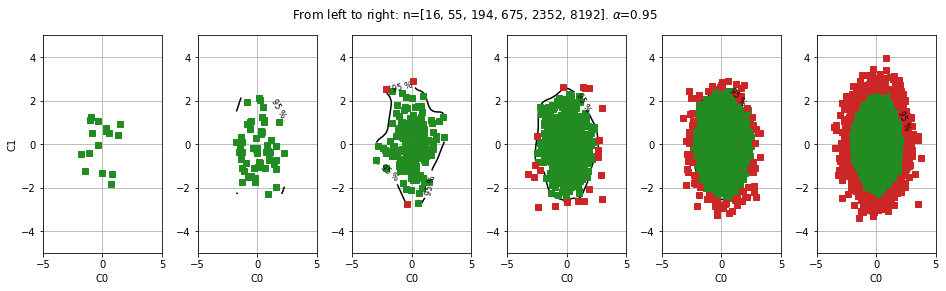

In [12]:
sample_array = [int(i) for i in np.logspace(4, 13, 6, base=2.0)]
grid = ot.GridLayout(1, len(sample_array))
for i in tqdm.tqdm(range(len(sample_array))):
    graph = draw_region(gaussian_process, sample_size=sample_array[i])
    bounding_box = graph.getBoundingBox()
    lower_bound = bounding_box.getLowerBound()
    upper_bound = bounding_box.getUpperBound()
    upper_bound = ot.Point([5.0] * 2)
    lower_bound = -upper_bound
    bounding_box.setLowerBound(lower_bound)
    bounding_box.setUpperBound(upper_bound)
    graph.setBoundingBox(bounding_box)
    if i > 0:
        graph.setYTitle("")
    grid.setGraph(0, i, graph)
grid.setTitle(r"From left to right: n=%s. $\alpha$=%.2f" % (sample_array, alpha_max))
_ = draw_grid(grid, figure_size = (16.0, 4.0))
pl.subplots_adjust(wspace=0.3)

100%|██████████| 6/6 [00:01<00:00,  3.52it/s]


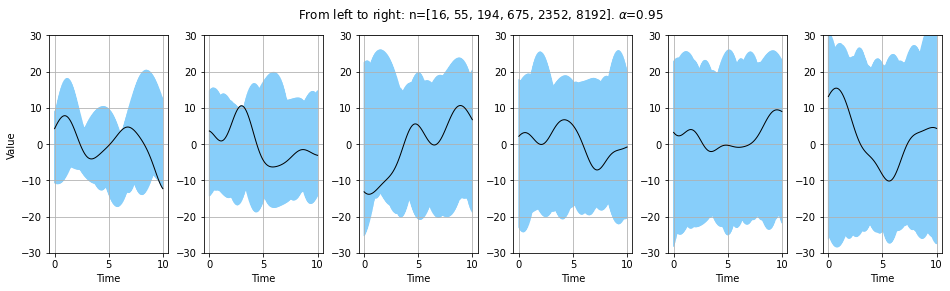

In [21]:
sample_array = [int(i) for i in np.logspace(4, 13, 6, base=2.0)]
grid = ot.GridLayout(1, len(sample_array))
for i in tqdm.tqdm(range(len(sample_array))):
    graph = draw_band(gaussian_process, sample_size=sample_array[i], number_of_components = 1)
    bounding_box = graph.getBoundingBox()
    lower_bound = bounding_box.getLowerBound()
    upper_bound = bounding_box.getUpperBound()
    upper_bound[1] = 30.0
    lower_bound[1] = -upper_bound[1]
    bounding_box.setLowerBound(lower_bound)
    bounding_box.setUpperBound(upper_bound)
    graph.setBoundingBox(bounding_box)
    if i == 0:
        graph.setYTitle("Value")
    graph.setXTitle("Time")
    grid.setGraph(0, i, graph)
grid.setTitle(r"From left to right: n=%s. $\alpha$=%.2f" % (sample_array, alpha_max))
_ = draw_grid(grid, figure_size = (16.0, 4.0))
pl.subplots_adjust(wspace=0.3)